# House prices analysis for Kaggle competition

by
Greg Pelletier

#### The analysis documented in this notebook resulted in a leaderboard score of 0.11988 (rank 247). Any score between 0.1 to 0.15 is considered to be a "good" score.

The Kaggle House Price Competition is a challenge that encourages the application of advanced regression techniques and creative feature engineering to build models that can accurately predict house prices. Participants explore the data, create and engineer features, build models, and submit predictions. The competition is an excellent starting point for practical experience in data science and machine learning. The following link is the official Web page for the kaggle house price competition:

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

### EasyMLR - Python Tools for Machine Learning Regression 

In this notebook I analyze the kaggle house price data using a blend of methods available at this link to the EasyMLR module:

https://github.com/gjpelletier/EasyMLR

The EasyMLR module includes the following main Python functions to facilitate the use of sklearn, XGBoost, LightGBM, statsmodels, and optuna solvers: 
 
 - **lasso** - LassoCV, LassoLarsCV, and LassoLarsIC using AIC/BIC
 - **ridge** - RidgeCV and Ridge using VIF
 - **elastic** - ElasticNetCV
 - **gbr** - GradientBoostingRegressor with user-specified hyper-parameters
 - **xgb** - XGBoostRegressor with user-specified hyper-parameters
 - **xgb_auto** - XGBoostRegressor with automatic cross-validated calibration of the best hyper-parameters
 - **lgbm** - LGBMRegressor with user-specified hyper-parameters
 - **svr** - SVR Epsilon-Support Vector Regression with user-specified hyper-parameters
 - **stacking** - StackingRegressor
 - **stepwise** - Stepwise multiple linear regression to minimize MSE, AIC, or BIC

### Kaggle competition leaderboard score using this notebook

The analysis documented in this notebook resulted in a leaderboard score of 0.11988 (rank 247). Any score between 0.1 to 0.15 is considered to be a "good" score.

### Installing EasyMLR

Use the following command in your Python environment to install EasyMLR

In [1]:
# pip install git+https://github.com/gjpelletier/EasyMLR.git --upgrade

# Import libraries

In [2]:
import numpy as np  # linear algebra
import pandas as pd  #
from datetime import datetime

from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

import os
import scipy.stats as stats
import matplotlib.pyplot as plt

# Read train and test data

In [3]:
# read train data into dataframe train
train_path = "/mnt/c/z/kaggle/house_prices/data/train.csv"
train = pd.read_csv(train_path)
print("Full train dataset shape is {}".format(train.shape))
# print(df_train.head())

# read test data into dataframe test
test_path = "/mnt/c/z/kaggle/house_prices/data/test.csv"
test = pd.read_csv(test_path)
print("Full test dataset shape is {}".format(test.shape))
# print(df_test.head())

Full train dataset shape is (1460, 81)
Full test dataset shape is (1459, 80)


# Data cleaning, feature transformations, final features

The data cleaning, feature transformations, feature engineering, and final features in this section were adapted from the following publicly posted python code:

https://www.kaggle.com/code/itslek/blend-stack-lr-gb-0-10649-house-prices-v57

In [4]:
train_ID = train['Id']
test_ID = test['Id']
# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

# Deleting outliers
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)

# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train.SalePrice.reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

In [5]:
features = pd.concat([train_features, test_features]).reset_index(drop=True)
print(features.shape)
# Some of the non-numeric predictors are stored as numbers; we convert them into strings 
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

features['Functional'] = features['Functional'].fillna('Typ')
features['Electrical'] = features['Electrical'].fillna("SBrkr")
features['KitchenQual'] = features['KitchenQual'].fillna("TA")
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

features["PoolQC"] = features["PoolQC"].fillna("None")

(2917, 79)


In [6]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)

features.update(features[objects].fillna('None'))

features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))


In [7]:
# Filling in the rest of the NA's

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)

In [8]:
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    # features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))
    features[i] = np.log1p(features[i])

features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

# simplified features
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# Additional feature engineering

These features were added/modified based on some other publicly posted ideas 

In [9]:
# # The commented out features made the score signficantly worse so were removed from future versions
# # The uncommented features make sense but made only a very slight change in the score (tiny bit worse)

# features['age_at_sell'] = pd.to_numeric(features['YrSold']) - pd.to_numeric(features['YearBuilt'])
# # features['remodel'] = np.where(features['YearRemodAdd'] == features['YearBuilt'], 0, 1)
# features['MoSold'] = (-np.cos(0.5236 * pd.to_numeric(features['MoSold'])))   # 2 * np.pi / 12 = 0.5236

# Split the combined features back into the train and test subsets

In [10]:
print(features.shape)
final_features = pd.get_dummies(features).reset_index(drop=True)
print(final_features.shape)

(2917, 86)
(2917, 333)


In [11]:
X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(X):, :]

print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

X (1458, 333) y (1458,) X_sub (1459, 333)


In [12]:
# Note: I can't find documentation of how these outliers were discovered
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

In [13]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')

In [14]:
X = X.drop(overfit, axis=1).copy()
X_sub = X_sub.drop(overfit, axis=1).copy()

print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

X (1453, 331) y (1453,) X_sub (1459, 331)


# Blended regression using EasyMLR

Next we will use functions from EasyMLR (https://github.com/gjpelletier/EasyMLR) to perform the regression analysis. 

Note that the EasyMLR functions standardize the X inputs by default. 

Fitting Lasso regression models, please wait ...


Lasso regression statistics of best models in model_outputs['stats']:


| Statistic          |         LassoCV |     LassoLarsCV |    LassoLarsAIC |    LassoLarsBIC |
|:-------------------|----------------:|----------------:|----------------:|----------------:|
| alpha              |     0.00327306  |     0.00320511  |     0.00209974  |     0.00566839  |
| r-squared          |     0.943388    |     0.94367     |     0.947044    |     0.936818    |
| adjusted r-squared |     0.93893     |     0.939279    |     0.941394    |     0.933666    |
| n_samples          |  1453           |  1453           |  1453           |  1453           |
| df residuals       |  1347           |  1348           |  1313           |  1384           |
| df model           |   105           |   104           |   139           |    68           |
| F-statistic        |   213.778       |   217.138       |   168.93        |   301.779       |
| Prob (F-statistic) |

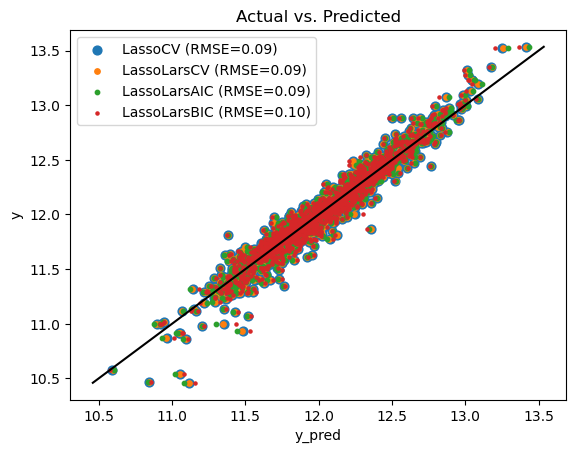

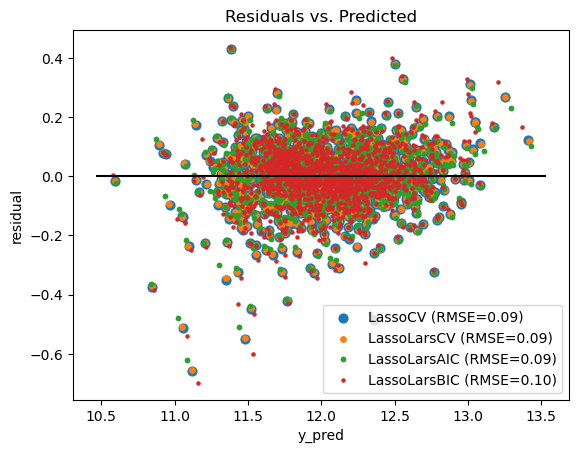

In [95]:
# LassoCV
from EasyMLR import lasso
lasso_model, lasso_output = lasso(X, y, verbose=1)
LassoCV_model = lasso_model['LassoCV']
LassoAIC_model = lasso_model['LassoLarsAIC']

Fitting Ridge regression models, please wait ...


Ridge regression statistics of best models in model_outputs['stats']:


| Statistic          |         RidgeCV |        RidgeVIF |
|:-------------------|----------------:|----------------:|
| alpha              |   107.227       |   162.975       |
| r-squared          |     0.951436    |     0.949704    |
| adjusted r-squared |     0.937041    |     0.934795    |
| n_samples          |  1453           |  1453           |
| df residuals       |  1121           |  1121           |
| df model           |   331           |   331           |
| F-statistic        |    66.3508      |    63.9485      |
| Prob (F-statistic) |     1.11022e-16 |     1.11022e-16 |
| RMSE               |     0.0874495   |     0.0889958   |
| Log-Likelihood     |  1478.8         |  1453.33        |
| AIC                | -2293.6         | -2242.66        |
| BIC                |  -540.177       |  -489.241       |


Done
Time elapsed: 33.54 sec


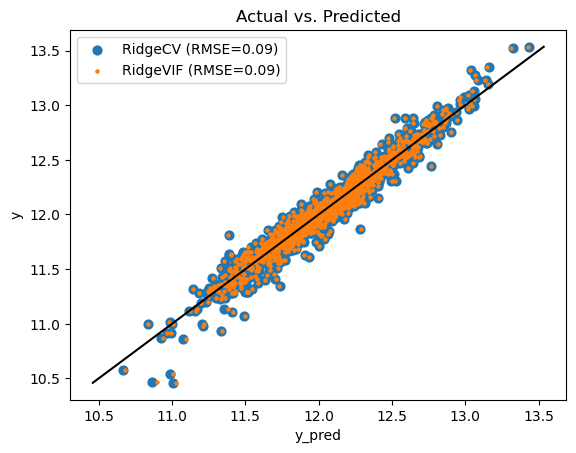

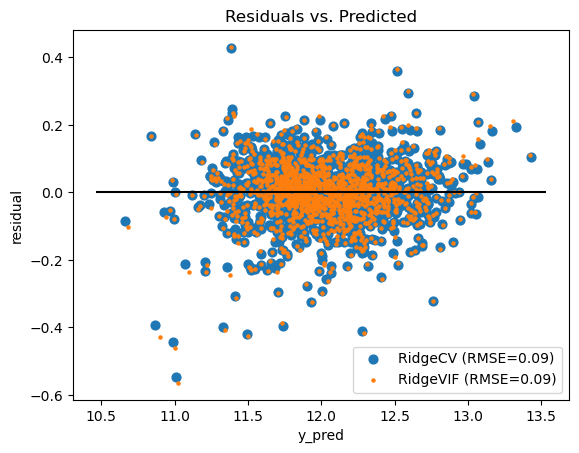

In [22]:
# RidgeCV
from EasyMLR import ridge
ridge_model, ridge_output = ridge(X, y, verbose=1)
RidgeCV_model = ridge_model['RidgeCV']

Fitting Elastic Net regression model, please wait ...


ElasticNetCV regression statistics of best model in model_outputs['stats']:


| Statistic          |    ElasticNetCV |
|:-------------------|----------------:|
| alpha              |     0.0109102   |
| r-squared          |     0.943326    |
| adjusted r-squared |     0.938818    |
| n_samples          |  1453           |
| df residuals       |  1346           |
| df model           |   106           |
| F-statistic        |   211.358       |
| Prob (F-statistic) |     1.11022e-16 |
| RMSE               |     0.0944698   |
| Log-Likelihood     |  1366.6         |
| AIC                | -2519.2         |
| BIC                | -1954.09        |
| L1-ratio           |     0.3         |


Done
Time elapsed: 184.71 sec


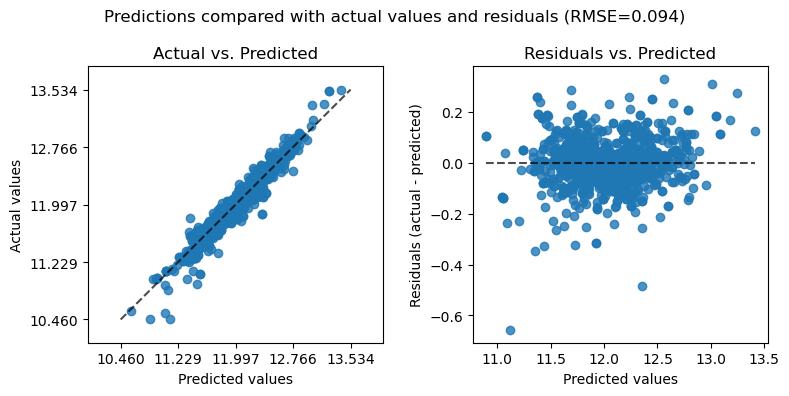

In [23]:
# ElasticNetCV
from EasyMLR import elastic
elastic_model, elastic_output = elastic(X, y, verbose=1)
ElasticNetCV_model = elastic_model['ElasticNetCV']

Running optuna to find best parameters, could take a few minutes, please wait...
Fitting XGBRegressor model with best parameters, please wait ...
XGBRegressor statistics of fitted model in model_outputs['stats']:


| Statistic   |   XGBRegressor |
|:------------|---------------:|
| r-squared   |       0.981437 |
| RMSE        |       0.054066 |
| n_samples   |    1453        |


Done
Time elapsed: 519.08 sec


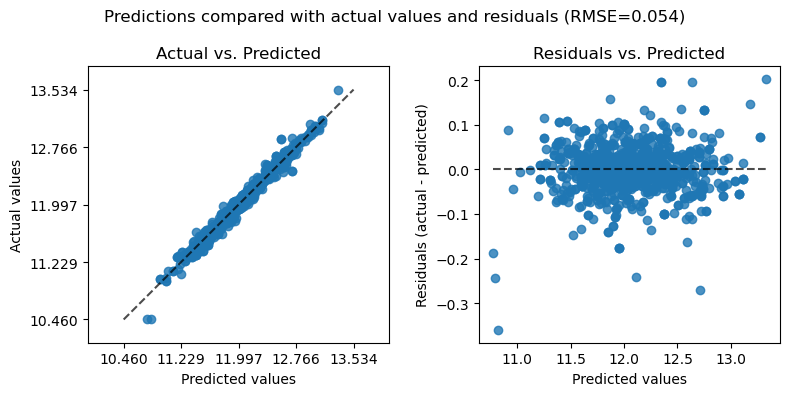

In [16]:
# XGBoost with automatic CV optimization of parameters
from EasyMLR import xgb_auto
xgb_auto_model, xgb_auto_output = xgb_auto(X, y, n_trials=100) 

Fitting XGBRegressor model, please wait ...


XGBRegressor statistics of fitted model in model_outputs['stats']:


| Statistic   |   XGBRegressor |
|:------------|---------------:|
| r-squared   |      0.986315  |
| RMSE        |      0.0464215 |
| n_samples   |   1453         |


Done
Time elapsed: 8.03 sec


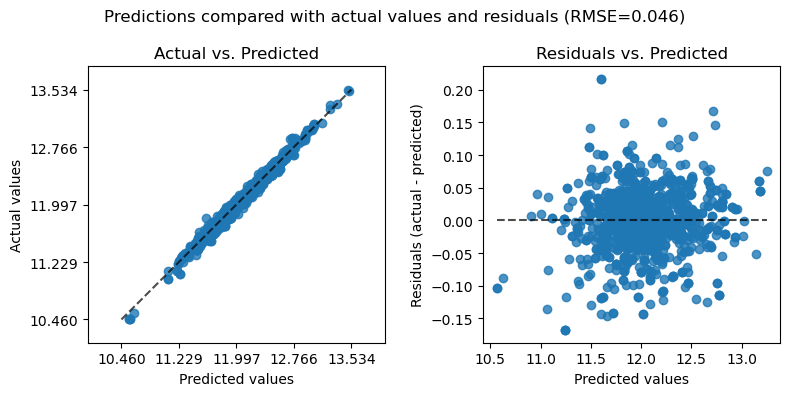

In [20]:
# XGBoost using params from https://www.kaggle.com/niteshx2/kernel-housing-prices-using-dummy-vars
from EasyMLR import xgb
xgb_model, xgb_output = xgb(X, y, 
    learning_rate=0.01,n_estimators=3460,
    max_depth=3, min_child_weight=0,
    gamma=0, subsample=0.7,
    colsample_bytree=0.7,
    objective='reg:linear', nthread=-1,
    scale_pos_weight=1, seed=27,
    reg_alpha=0.00006)

Fitting LGBMRegressor model, please wait ...


LGBMRegressor statistics of fitted model in model_outputs['stats']:


| Statistic   |   LGBMRegressor |
|:------------|----------------:|
| r-squared   |        0.97233  |
| RMSE        |        0.066009 |
| n_samples   |     1453        |


Done
Time elapsed: 464.62 sec


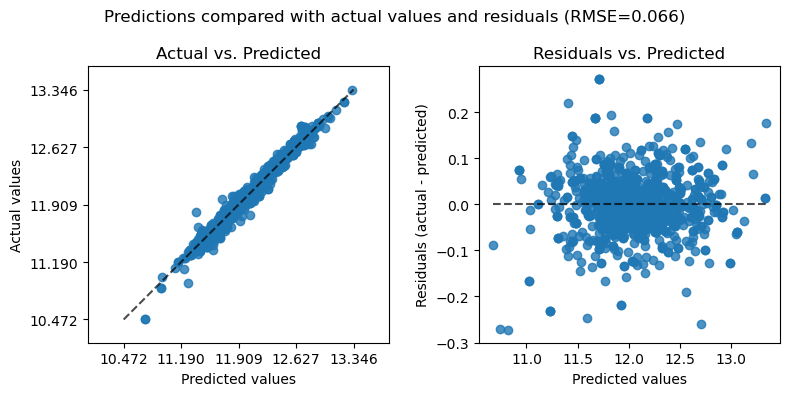

In [39]:
# LightGBM using params from https://www.kaggle.com/niteshx2/kernel-housing-prices-using-dummy-vars
from EasyMLR import lgbm
lgbm_model, lgbm_output = lgbm(X, y,
    objective='regression', 
    num_leaves=4,
    learning_rate=0.01, 
    n_estimators=5000,
    max_bin=200, 
    bagging_fraction=0.75,
    bagging_freq=5, 
    bagging_seed=7,
    feature_fraction=0.2,
    feature_fraction_seed=7,
    verbosity=-1)

Fitting GradientBoostingRegressor model, please wait ...


GradientBoostingRegressor statistics of fitted model in model_outputs['stats']:


| Statistic   |   GradientBoostingRegressor |
|:------------|----------------------------:|
| r-squared   |                   0.989487  |
| RMSE        |                   0.0406872 |
| n_samples   |                1453         |


Done
Time elapsed: 6.05 sec


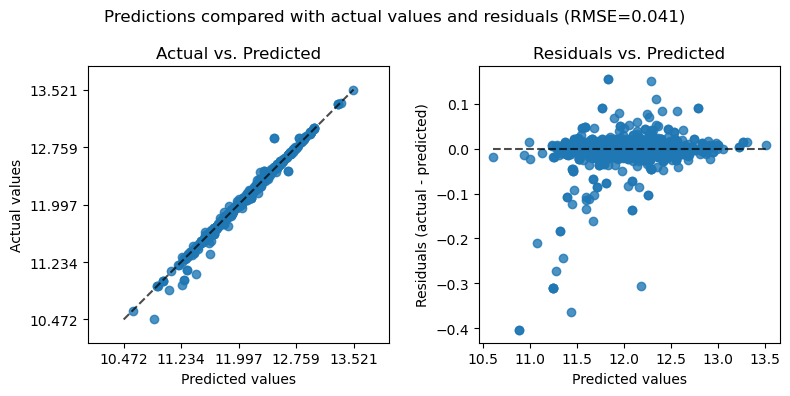

In [21]:
# GradientBoostingRegressor
from EasyMLR import gbr
gbr_model, gbr_output = gbr(X, y,
    n_estimators=3000, learning_rate=0.05, 
    max_depth=4, max_features='sqrt', min_samples_leaf=15, 
    min_samples_split=10, loss='huber', random_state =42)                             

Fitting SVR model, please wait ...


SVR statistics of fitted model in model_outputs['stats']:


| Statistic   |          SVR |
|:------------|-------------:|
| r-squared   |    0.991118  |
| RMSE        |    0.0373992 |
| n_samples   | 1453         |


Done
Time elapsed: 0.70 sec


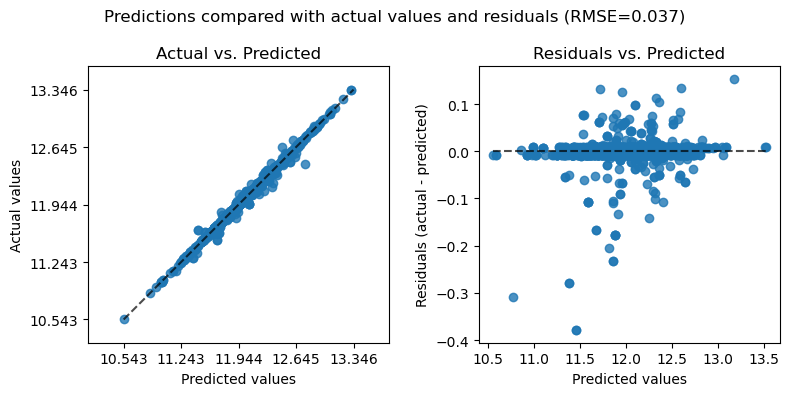

In [18]:
# SVR using params from https://www.kaggle.com/niteshx2/kernel-housing-prices-using-dummy-vars
# Note: SVR was not included in the final blend for the best score
from EasyMLR import svr
svr_model, svr_output = svr(X, y, C= 20, epsilon= 0.008, gamma=0.0003)

# Predictions for submission

In [107]:
# Standardize X_sub with the same scaler that was used for X in stacking
scaler = xgb_output['scaler']
X_sub_scaled = scaler.transform(X_sub)
# Convert scaled arrays into pandas dataframes with same column names as X
X_sub_scaled = pd.DataFrame(X_sub_scaled, columns=X_sub.columns)
# Copy index from unscaled to scaled dataframes
X_sub_scaled.index = X_sub.index
# print(X_sub_scaled.shape)
# X_sub_scaled

In [108]:
# predicted y from each model using the standardized X_Sub
y_pred_xgb = xgb_model.predict(X_sub_scaled)
y_pred_xgb_auto = xgb_auto_model.predict(X_sub_scaled)
y_pred_lgbm = lgbm_model.predict(X_sub_scaled)
y_pred_gbr = gbr_model.predict(X_sub_scaled)
y_pred_svr = svr_model.predict(X_sub_scaled)
y_pred_lasso = LassoCV_model.predict(X_sub_scaled)
y_pred_lasso_aic = LassoAIC_model.predict(X_sub_scaled)
y_pred_ridge = RidgeCV_model.predict(X_sub_scaled)
y_pred_elastic = ElasticNetCV_model.predict(X_sub_scaled)

In [109]:
'''
# blended predictions by averaging of selected models 
# the best score was acheived by omitting SVR from the blend
# v32b08
y_pred = (
    y_pred_xgb_auto +
    y_pred_lgbm + 
    y_pred_gbr +
    y_pred_lasso +
    y_pred_ridge +
    y_pred_elastic) / 6
''';

In [110]:
# '''
# blended predictions by averaging of selected models 
# the best score was acheived by omitting SVR from the blend
# v32b02 (best score: 0.11988)
y_pred = (
    y_pred_xgb +
    y_pred_lgbm + 
    y_pred_gbr +
    y_pred_lasso +
    y_pred_ridge +
    y_pred_elastic) / 6
# ''';

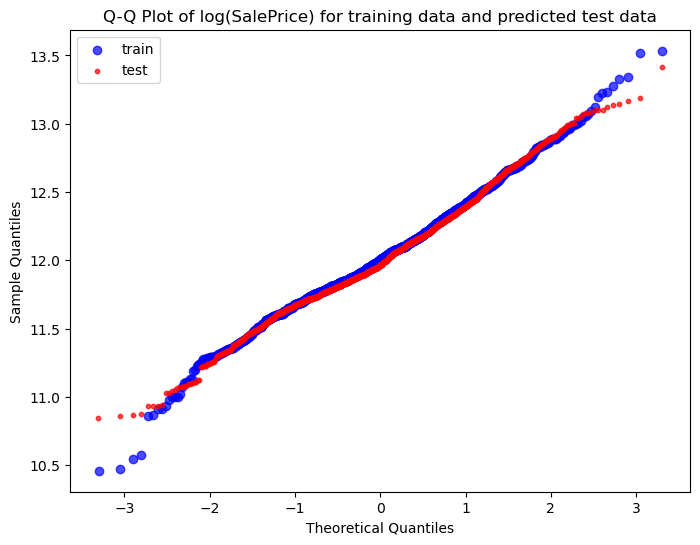

In [111]:
# QQ plot to compare the log-transformed y and y_pred

data1 = y        # training data
data2 = y_pred   # predicted from test X_sub

# Generate Q-Q plot data for both datasets
qq1 = stats.probplot(data1, dist="norm")
qq2 = stats.probplot(data2, dist="norm")

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the first dataset
plt.scatter(qq1[0][0], qq1[0][1], color='blue', label='train', alpha=0.7)

# Plot the second dataset
plt.scatter(qq2[0][0], qq2[0][1], color='red', label='test', alpha=0.7, s=10)

# Customize the plot
plt.title('Q-Q Plot of log(SalePrice) for training data and predicted test data')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.legend()
# plt.grid()

# Show the plot
plt.show()

In [104]:
# read test data again to retrieve the test Id
test_path = "/mnt/c/z/kaggle/house_prices/data/test.csv"
test2 = pd.read_csv(test_path)
# print("Full test dataset shape is {}".format(df_test.shape))
# print(test2.head())

In [112]:
# Make the csv file to submit the predictions to kaggle 
submission = pd.DataFrame(
    {
        "Id": test2['Id'],
        "SalePrice": np.expm1(y_pred)
    }
    )
submission
submission.to_csv('submission_blend_v32b02.csv', index=False) 